In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import measures

np.random.seed(0)

In [19]:
df = pd.read_csv("./../out.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
df = df.loc[400:1400] # first 1000 segments
df = df.reset_index().drop('index', axis=1)
df

,segment,label
0,obstin bigot offici set defianc liber initi go...,c
1,ask thing and proper repli must given It said ...,c
2,co-oper attempt dethron but influenc act parli...,c
3,busi necessari parliament elect execut cours f...,c
4,behind treasuri bench nay possibl rise man sit...,c
...,...,...
995,lamb chop fri tomato potato la crãªme rais bis...,g
996,glass rhine wine IV glass water V glass champa...,g
997,cover cloth set away cool place hour dinner ti...,g
998,transpar veil egg cook white firm lift griddl ...,g


In [21]:
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models

documents = df['segment'].tolist()


doc_tokenized = [simple_preprocess(doc, min_len=1, max_len=2000) for doc in documents]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

tfidf = models.TfidfModel(BoW_corpus)
corpus_tfidf = tfidf[BoW_corpus]

In [22]:
# # display word and occurence
# tfidf_doc_0 = BoW_corpus[0]
# for i in range(0, len(tfidf_doc_0)):
#     print("Word {} (\"{}\") appears {} time.".format(tfidf_doc_0[i][0], dictionary[tfidf_doc_0[i][0]], tfidf_doc_0[i][1]))

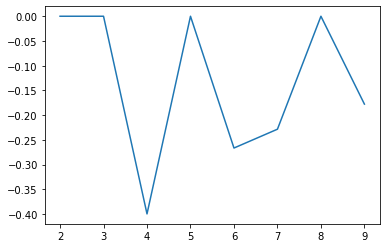

In [23]:
result_num_topic = measures.best_num_topic(corpus_tfidf, dictionary ,10)
# check get_coherence_per_topic()

,topic,score
0,2,0.412759
1,3,0.504164
2,4,0.574045
3,5,0.584414
4,6,0.544864
5,7,0.541012
6,8,0.543975
7,9,0.521637
8,10,0.504344
9,11,0.506217


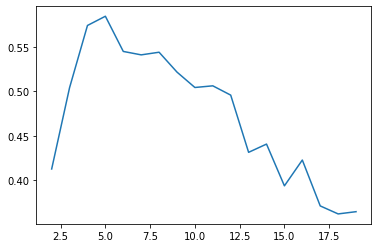

In [24]:
results = measures.best_silhouette_score(model = KMeans(), corpus = corpus_tfidf, dictionary = dictionary , max_n_clusters = 20, best_num_topic=5)
results

In [25]:
best_at = list(results['score']).index(results['score'].max())+2
print("Peak at k={}, silhouette_score = {}".format(best_at, results['score'].max()))

Peak at k=5, silhouette_score = 0.5844141185054668


In [26]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=best_at)
corpus_lsi = lsi_model[corpus_tfidf] 

cm = CoherenceModel(model=lsi_model, corpus=corpus_lsi, coherence='u_mass')
cm.get_coherence()


0.0

In [27]:
# for doc, as_text in zip(corpus_lsi, documents):
#     print(doc, as_text)

In [28]:
X = np.array([[tup[1] for tup in arr] for arr in corpus_lsi])
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

In [29]:
from gensim.matutils import corpus2csc

corpus_tfidf_sparse = corpus2csc(corpus_tfidf)

kmeans_pred = kmeans.fit_predict(corpus_tfidf_sparse.T)

In [30]:
from gensim.matutils import corpus2csc
pred_map = dict()
k = 5

for i in range(0, 5):
    count = np.bincount(kmeans_pred[i * 200 : i * 200 + 200])
    np.ndarray.resize(count, (1,k))
    count = count[0]
    index = np.where(count == max(count))[0][0]
    label = chr(ord('c')+i)
    pred_map[index] = label
    print(label + ":" + np.array2string(count) + "\t" + label + " mapped to " + str(index))

c:[  0   4   0 196   0]	c mapped to 3
d:[  0 200   0   0   0]	d mapped to 1
e:[200   0   0   0   0]	e mapped to 0
f:[  0   3   0   0 197]	f mapped to 4
g:[  0   9 191   0   0]	g mapped to 2


In [31]:
mapped_pred = []
for ele in kmeans_pred:
    mapped_pred.append(pred_map[ele])
mapped_pred = np.asarray(mapped_pred) # predicted label

In [32]:
kappa = measures.get_kappa(df['label'], mapped_pred)
rand_score = measures.get_rand_score(df['label'], mapped_pred)
silhouette = measures.get_silhouette_score(corpus_lsi, kmeans_pred)
coherence = measures.get_coherence(cm)

kappa: 0.98
rand score: 0.9600610150924449
silhouette score: 0.5340391262652369
coherence: 0.0


C:\Users\zwang684\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


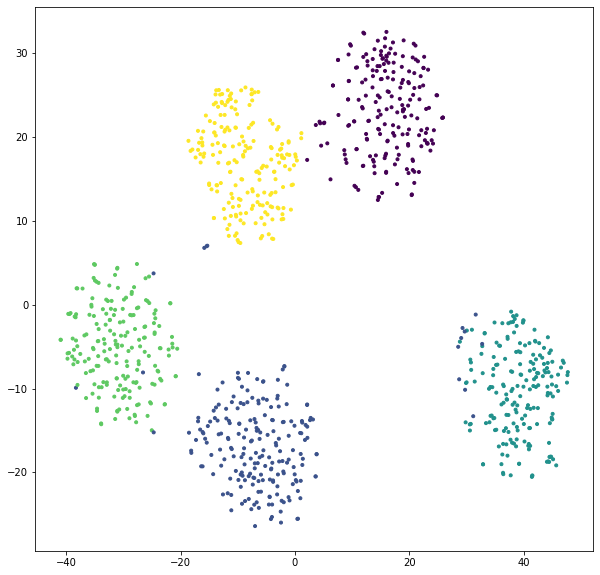

In [33]:
from sklearn.manifold import TSNE

tfidf_embedded = TSNE(n_components=2, 
                    perplexity=50, 
                    learning_rate = 'auto',
                    n_iter=1000, 
                    random_state=0).fit_transform(corpus_tfidf_sparse.T) #corpus_tfidf_sparse.T

fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfidf_embedded[:, 0], tfidf_embedded[:, 1], marker = ".", c = kmeans_pred)
plt.show()